In [1]:
import sys
sys.path.append('../')
import re
import os
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
matplotlib.style.use('ggplot')

In [2]:
def contains_null(dataframe):
    missing_df = dataframe.isnull().sum(axis=0).reset_index()
    missing_df.columns = ['column_name', 'missing_count']
    missing_df['missing_rate'] = 1.0 * missing_df['missing_count'] / dataframe.shape[0]
    missing_df = missing_df[missing_df.missing_count > 0]
    missing_df = missing_df.sort_values(by='missing_count', ascending=False)
    return missing_df

In [3]:
!ls ../input

cleaned      mrc_dataset_old  raw	 text_analysis	yzq_test
mrc_dataset  original	      README.md  yzq_para_test


In [4]:
train_df = pd.read_csv('../input/original/train_round_0.csv', sep=',')
test_df = pd.read_csv('../input/original/test_data_r0.csv', sep=',')

In [5]:
print(train_df.shape, test_df.shape)
train_df.head(1)

(24843, 16) (4969, 13)


,answer,bridging_entity,content1,content2,content3,content4,content5,keyword,question,supporting_paragraph,title1,title2,title3,title4,title5,question_id
0,@content5@卡尔文森号航母@content5@,无,据美国媒体9月10日报道称，近日部署在美国东海岸多个军事基地的3艘核动力航母出现了罕见的一幕...,艾森豪威尔号航空母舰。它是美国尼米兹级核动力航空母舰的二号舰，舰名承袭自参加过第二次世界大战...,自2016年以来，美国海军第一次出现两艘核动力航母齐聚地中海的特殊部署，这意味着美国准备对某...,伊朗塔斯尼姆通讯社日前在社交媒体上发布了一段视频，视频中显示一艘航母在驱逐舰的护航下正在海面...,作为全世界唯一的超级大国，美国拥有10艘尼米兹核动力航母，其航母舰队和海军实力足以能够秒杀任...,“艾森豪威尔”号核动力航母,参与美韩举行的“鹞鹰”联合军演的是哪艘航母？,@content5@如今抵达西太平洋的美卡尔文森号航母，已经在该地区执行了一个多月的任务，并...,美军3艘核动力航母紧急机动，情况十分突然 高官：差点出了大事！,世界上最先进的航空母舰：艾森豪威尔号航空母舰！,局势十分紧张，美军两艘超级航母坐镇地中海 在向谁发出警告？,美航母抵近伊朗，伊战机紧急起飞，传回现场画面：甲板满是战机,美法曾联手包围俄航母 如今四国又来给中国添堵,Q_05193ghdyd


In [6]:
test_df.head(2)

,content1,content2,content3,content4,content5,keyword,question,title1,title2,title3,title4,title5,question_id
0,贝尔纳蒂斯早期型潜艇上的初级空气压缩机安装在控制室内，由San Giorgio公司研制，可产...,俄罗斯军事灾难一桩又一桩，航母在船坞沉没事件中受损，潜艇事故导致大量精锐海军军官死亡，又屡次...,日前，俄罗斯公布了北风之神级战略核潜艇“弗拉基米尔大公”号的近照，该艇为北风之神级的3号艇，...,7月1日，俄罗斯海军遭遇了十分沉痛的悲剧，一艘核潜艇在水下执行任务时突然着火，14名高官不幸...,参考消息网7月4日报道 俄媒称，俄罗斯国防部报告了一起1日发生的悲剧：一艘深海潜艇在潜航时失...,“维涅罗”号,世界上最小的核潜艇是哪艘？,二战时的意大利潜艇,俄军又一次遭遇死神来袭！航母潜艇出事没多久，又曝出大爆炸灾难,俄军最强“核黑鱼”曝光，龟背已去除，和094核潜艇差距不小啊,核潜艇水下着火，却意外暴露俄军最神秘单位！苏联解体后实力不减,深海潜艇失火令俄军方震惊：隶属俄最神秘部队 起因成谜,Q_32174nsdcj
1,今年5月底，朝鲜公开了约50分钟长的宣传纪录片——“掀起白头山训练热潮，培养无敌强军”。在片...,朝鲜此前曾表达善意，愿意以停止核试验换区美韩不进行联合演习。而在美韩执意举行联合军演后，朝鲜...,乌克兰宣布成功测试了一款陆基巡航导弹并且公布了一段视频，对此网友发现乌克兰周二试射的新型巡航...,英国《简氏防务周刊》网站8月15日发表了里兹万·拉赫马特的题为《印度发布中程反舰导弹信息请求...,前不久，据外媒报道，印度军方有意采购一款外国的中程反舰导弹来取代部分苏俄提供的反舰导弹。外界...,Kh-35中程反舰导弹,第二次世界大战时期，对于水面战斗舰艇来讲，最具威力的武器是什么？,朝鲜公开新型反舰导弹 性能堪比俄制Kh-35,朝鲜海军新型隐身导弹艇获金正恩赞扬 发射其国产Kh-35反舰导弹,乌克兰实力倒退了吗？研制了一款类似KH-35的巡航导弹,印度欲购新中程反舰导弹 反制中国海军进入印度洋,一大国欲购新中程岸舰导弹，选中法国“飞鱼”的概率很大！,Q_42346jgcgs


In [7]:
contains_null(train_df)

,column_name,missing_count,missing_rate


In [8]:
train_df['content1_len'] = train_df['content1'].str.len()
train_df['content2_len'] = train_df['content2'].str.len()
train_df['content3_len'] = train_df['content3'].str.len()
train_df['content4_len'] = train_df['content4'].str.len()
train_df['content5_len'] = train_df['content5'].str.len()

test_df['content1_len'] = test_df['content1'].str.len()
test_df['content1_len'] = test_df['content2'].str.len()
test_df['content1_len'] = test_df['content3'].str.len()
test_df['content1_len'] = test_df['content4'].str.len()
test_df['content1_len'] = test_df['content5'].str.len()

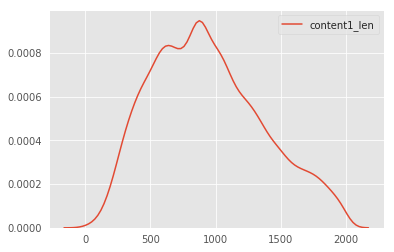

In [9]:
sns.kdeplot(train_df[train_df['content1_len'] < 2000]['content1_len'])

In [10]:
np.mean(train_df[train_df['content1_len'] < 2000]['content1_len'])

936.19871669279

## document 长度分布

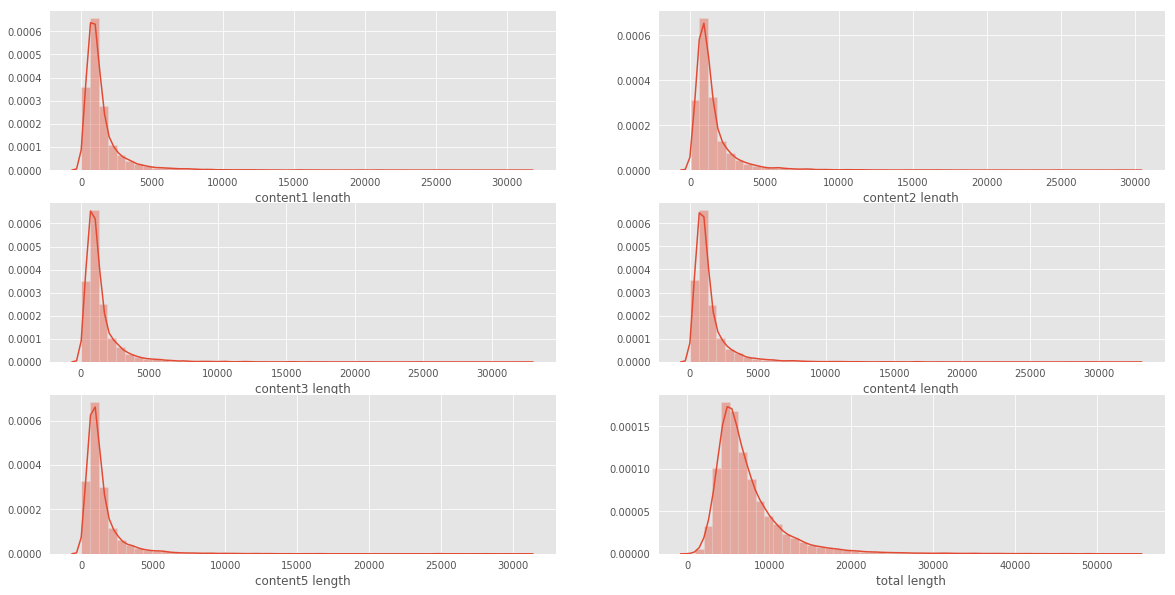

In [9]:
plt.figure(figsize=(20,10))
plt.subplot(321)
sns.distplot(train_df['content1_len'], axlabel='content1 length')
plt.subplot(322)
sns.distplot(train_df['content2_len'], axlabel='content2 length')
plt.subplot(323)
sns.distplot(train_df['content3_len'], axlabel='content3 length')
plt.subplot(324)
sns.distplot(train_df['content4_len'], axlabel='content4 length')
plt.subplot(325)
sns.distplot(train_df['content5_len'], axlabel='content5 length')
plt.subplot(326)
sns.distplot(train_df['content1_len'] + train_df['content2_len'] + train_df['content3_len'] + 
             train_df['content4_len'] + train_df['content5_len'], axlabel='total length')
plt.show()

## 答案长度分布

In [10]:
train_df['answer_str'] = train_df['answer'].str.replace('@content\d@', '')

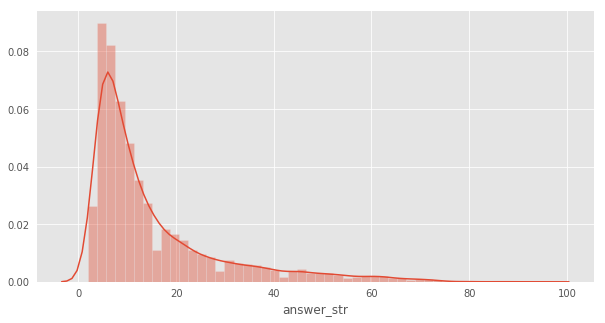

In [11]:
plt.figure(figsize=(10,5))
sns.distplot(train_df['answer_str'].str.len())
plt.show()

## 问题长度分布

In [12]:
train_df['question_len'] = train_df['question'].map(len)

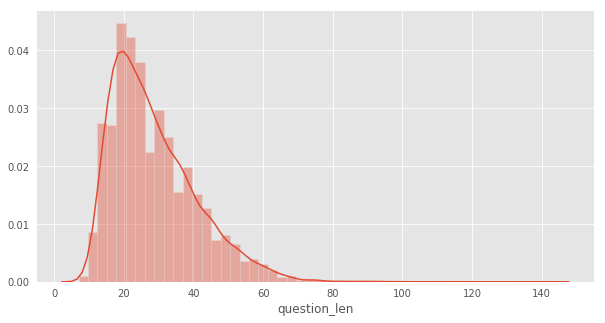

In [13]:
plt.figure(figsize=(10,5))
sns.distplot(train_df['question_len'])
plt.show()

## 答案所在篇章分布

In [14]:
ans_pattern = re.compile(r'@content\d@')

def find_answer_in_docid(answer):
    docs = ans_pattern.findall(answer)
    return ','.join(list(set([doc[-2:-1] for doc in docs])))


In [15]:
train_df['answer_in_docid'] = train_df['answer'].map(find_answer_in_docid)

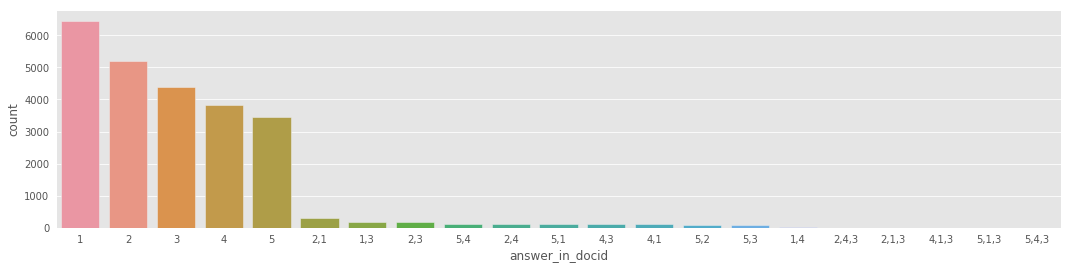

In [16]:
plt.figure(figsize=(18, 4))
sns.countplot(train_df['answer_in_docid'], order=train_df['answer_in_docid'].value_counts().index)
plt.show()

In [17]:
content_pattern = re.compile(r'@content\d@')
def find_support_para_in_docid(support_para):
    docs = content_pattern.findall(support_para)
    doc_ids = [doc[-2:-1] for doc in docs]
    doc_ids = sorted(doc_ids)
    return ','.join(doc_ids)

In [18]:
train_df['supporting_paragraph_in_docid'] = train_df['supporting_paragraph'].map(find_support_para_in_docid)

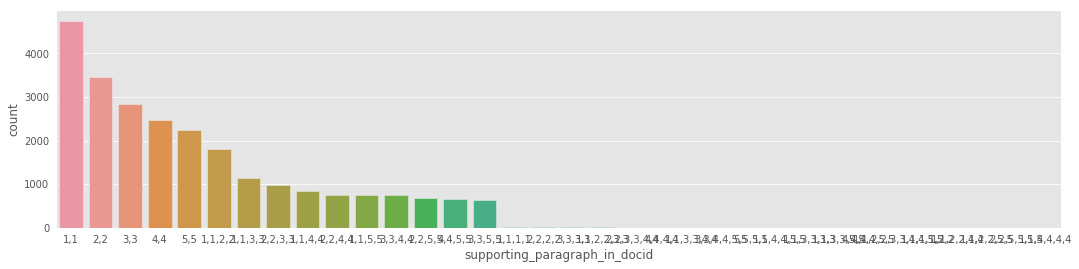

In [19]:
plt.figure(figsize=(18, 4))
sns.countplot(train_df['supporting_paragraph_in_docid'], order=train_df['supporting_paragraph_in_docid'].value_counts().index)
plt.show()

In [20]:
# 检测一个doc中是否包含多个 supporting_paragraph
def chech_supporting_paragraph(sp_docid):
    if '1,1,1,1' in sp_docid:
        return True
    elif '2,2,2,2' in sp_docid:
        return True
    elif '3,3,3,3' in sp_docid:
        return True
    elif '4,4,4,4' in sp_docid:
        return True
    elif '5,5,5,5' in sp_docid:
        return True
    else:
        return False

train_df['support_onedoc_multi_para'] = train_df['supporting_paragraph_in_docid'].map(chech_supporting_paragraph)

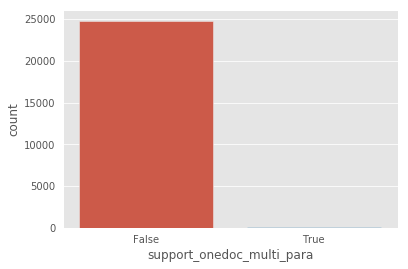

In [21]:
sns.countplot(train_df['support_onedoc_multi_para'])

In [22]:
train_df['support_onedoc_multi_para'].value_counts()

False    24793
True        50
Name: support_onedoc_multi_para, dtype: int64

**可以看出，一个 doc 可能存在多个 supporting_paragraph 的情况**

## 答案的基本模式，指导数据清洗策略

In [23]:
# 是否包含 url
train_df['answer_has_url'] = train_df['answer_str'].map(lambda x: 'http' in x or 'https' in x)

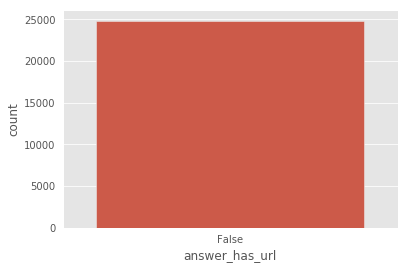

In [24]:
sns.countplot(train_df['answer_has_url'])

In [25]:
# 是否包含英文标点符号,!?等
train_df['answer_has_eng_punc'] = train_df['answer_str'].map(lambda x: ',' in x or '!' in x)

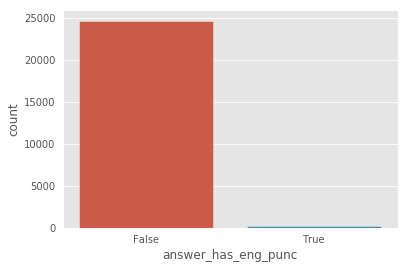

In [26]:
sns.countplot(train_df['answer_has_eng_punc'])

In [27]:
train_df['answer_str'][train_df['answer_has_eng_punc'] == True].head()

85                                               40,580吨
170    掠夺者最高速度可以达到每小时120公里。这款巨无霸的动力配置来自CUMMINS ISBe4柴...
234                   枪托与机匣配合紧密, 精度高, 线条流畅, 外形优雅的一贯优点. ,
333                                             61,170 吨
412                                             140,000把
Name: answer_str, dtype: object

## 问题和答案的对比

In [28]:
train_df[['question', 'answer_str', 'bridging_entity']].head()

,question,answer_str,bridging_entity
0,参与美韩举行的“鹞鹰”联合军演的是哪艘航母？,卡尔文森号航母,无
1,中菲关系焕发新的活力的好处是什么,实现了由转圜、巩固到提升的跨越式发展，为两国人民带来福祉，促进了地区和平稳定,无
2,海战开始，泰国海军一共损失了三艘什么艇？,鱼雷艇及吞武里号浅水重炮艇,无
3,"苏联把沙俄的""拉扎列夫海军上将""号改造后的重巡洋舰有多重？",8000多吨,红色高加索号
4,AW－159 “野猫”直升机的机长是多少米？,15.22米,无


In [29]:
train_df[['bridging_entity', 'supporting_paragraph', 'answer_str']].head()

,bridging_entity,supporting_paragraph,answer_str
0,无,@content5@如今抵达西太平洋的美卡尔文森号航母，已经在该地区执行了一个多月的任务，并...,卡尔文森号航母
1,无,@content1@习近平指出，近年来，中菲关系焕发新的活力，实现了由转圜、巩固到提升的跨越...,实现了由转圜、巩固到提升的跨越式发展，为两国人民带来福祉，促进了地区和平稳定
2,无,@content3@海战开始时从东面进入的两艘布干维尔级巡防舰合力击沉了一艘鱼雷艇，此战法军...,鱼雷艇及吞武里号浅水重炮艇
3,红色高加索号,"@content1@红色高加索号巡洋舰是苏联海军中的第一艘重巡洋舰，是沙俄1913年开工的""...",8000多吨
4,无,@content1@AW－159 “野猫”直升机机长15.22米，机高4.04米，最大巡航速...,15.22米


## 测试答案是否能根据字符串匹配直接定位

In [30]:
train_df.head(1)

,answer,bridging_entity,content1,content2,content3,content4,content5,keyword,question,supporting_paragraph,...,content3_len,content4_len,content5_len,answer_str,question_len,answer_in_docid,supporting_paragraph_in_docid,support_onedoc_multi_para,answer_has_url,answer_has_eng_punc
0,@content5@卡尔文森号航母@content5@,无,据美国媒体9月10日报道称，近日部署在美国东海岸多个军事基地的3艘核动力航母出现了罕见的一幕...,艾森豪威尔号航空母舰。它是美国尼米兹级核动力航空母舰的二号舰，舰名承袭自参加过第二次世界大战...,自2016年以来，美国海军第一次出现两艘核动力航母齐聚地中海的特殊部署，这意味着美国准备对某...,伊朗塔斯尼姆通讯社日前在社交媒体上发布了一段视频，视频中显示一艘航母在驱逐舰的护航下正在海面...,作为全世界唯一的超级大国，美国拥有10艘尼米兹核动力航母，其航母舰队和海军实力足以能够秒杀任...,“艾森豪威尔”号核动力航母,参与美韩举行的“鹞鹰”联合军演的是哪艘航母？,@content5@如今抵达西太平洋的美卡尔文森号航母，已经在该地区执行了一个多月的任务，并...,...,622,846,1281,卡尔文森号航母,22,5,"5,5",False,False,False


In [31]:
ans_pattern = re.compile(r'@content\d@')

def find_answer_in_docid(answer):
    docs = ans_pattern.findall(answer)
    return list(set([doc[-2:-1] for doc in docs]))

train_df['answer_in_docid'] = train_df['answer'].map(find_answer_in_docid)

In [32]:
def check_answer_match_in_doc(row):
    answer = row['answer']
    ans_in_docids = find_answer_in_docid(answer)
    total_ans_span_cnt = 0
    ans_match_in_doc_cnt = []
    for ans_docid in ans_in_docids:
        ans_results = answer.split('@content{}@'.format(ans_docid))
        for ans_str in ans_results:
            if ans_str != '' and '@content' not in ans_str:
                total_ans_span_cnt += 1
                ans_match_in_doc = ans_str in row['content{}'.format(ans_docid)]
                ans_match_in_doc_cnt.append(ans_match_in_doc)
    
    return sum(ans_match_in_doc_cnt) == total_ans_span_cnt

In [33]:
train_df[train_df['question_id']=='Q_05193ghdyd'].apply(lambda row:check_answer_match_in_doc(row), axis=1)

0    True
dtype: bool

In [34]:
train_df['answer_match_in_doc'] = train_df.apply(lambda row:check_answer_match_in_doc(row), axis=1)

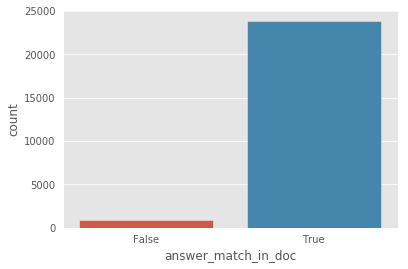

In [35]:
sns.countplot(train_df['answer_match_in_doc'])

In [36]:
train_df['answer_match_in_doc'].value_counts()

True     23893
False      950
Name: answer_match_in_doc, dtype: int64

**可以看出，96%的样本的答案是直接可以从doc里匹配定位得到的！**